# Medication Titration Master Notebook

### This notebook is a complete walkthrough of the data preprocessing, analysis, and machine learning model design used for the medication titration tool as part of my internship at Veta Health during Summer 2019. All associated code, such as classes and functions made within this notebook can be found in the same directory. This notebook demonstrates the use of those code pieces for the purpose of the internship. 


### Problem: 

Doctors regularly prescribe their patients medication even after they have left the hospital. The prescribing of those medications and the recommended frequencies is often based on factors such as pre-existing conditions, patient weight and height, age, and lab tests. However, it is often difficult to accuractly prescribe a dosage and frequency of a medication for any patient. It is therefore of interest to design a machine learning based model to predict ideal medication dosages and frequencies. 

### Challenges: 

Clinical/patient data is often very difficult to come by. Due to the high level of security required to protect patient information and the risk associated with the identification of patients using their clinical information, most patient data found within EHRs is not publicly available. Additionally, most patient data is very sparse and often incomplete. There also exists the challenges associated with medical termonologies used to define various features of clinical data. The terminologies used are not always consistent. The incompleteness and sparsity of clinical data makes it extremely difficult to produce statistical models that can acccuractely make any predictions of any kind at all, let alone the prediction of ideal medication and dosage for a patient. 

### Solutions: 

Fortunately, there are some sources of clinical data available. The most well-known and widely used ones are the MIMIC III critical care database and the eICU Collaborative Research Database curated by the Lab for Computational Physiology (LCP) at MIT. These two databases contains over 100 GB of patient data and is generously provided for free upon request. This data has been retrieved and used for the final modeling in this project. Prior to the availability of this data, other datasets were also used to make predictive models. Please refer to the the "Project Iterations" folder for those respective notebooks. You will find that those first iterations with those datasets were fairly unsucessful.

Even though there is significant data available through the LCP, it is not always complete data. However, it does provide easy ways to combine tables in its relational database to get tables in which one can find data for individual de-identified patients such as which medications they take, their vitals, and some of the tests that were administered to them. After preprocessing the data, transforming it, it was successfully used to build a predictive model for drug dosage and frequency prediction. Although it is by no means perfect as it doesn't provide consistent results from medication to medication, it is a great starting point upon which a preliminary medication titration product can be designed and deployed for use. 

### Dependacies:

All code found in this notebook has already been run. I have provided outputs of the results as I go through each bit of code. However, in order to rerun it and actually use it for more medication datasets, you will need the following on your machine, either locally or in a virtual environment. 

> Python 3.6

> Pandas

> Numpy

> Scikit-learn

> XGBoost (not Python wrapper version, actual XGBoost package)

> Tensorflow (2.0 is fine), Keras

> Matplotlib



***
***

### Import Dependacies

In [2]:
# Pandas
import pandas as pd

# This will enable us to display all columns and rows of a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# In some cases, an excessive amount of warnings appear. All warnings
# have been explored and none have any impact on models
import warnings

from collections import Counter

# All sklearn package methods needed
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score


# XGBoost
import xgboost as xgb

# Tensorflow, keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.utils import to_categorical

# Note that tensorflow and numpy might show some comptaibility issues. This is noted to be patched in a future update to tensorflow. It doesn't affect
# any of the neural network models. If you would like make the warnings disappear, rerun the entire code block.




***
***

### Load & View Dataset

In this section, we use the dataset acquired from the eICU database. This dataset, which represents the use of acetaminophen in a clinical setting, was queried with standard SQL (note: not legacy SQL) on Google's BigQuery console. Please refer to the "BigQuery SQL Files" folder for more information. Other drug's datasets can also be used for this purpose. Data loading was done using Pandas because Pandas allows us to easily see features (columns) and patient instances (rows) in a relational format usually referred to as a dataframe. It is very easy to query Pandas dataframes due to their relational format. Additionally, these dataframes work seamlessly with many machine learning (ML) packages like Sklearn and Tensorflow. They can also be made into numpy arrays if one so desires.

In [1405]:
# Request user to type in filepath of dataset and store filepath in
# variable 'filepath'.

filepath = input("Please paste the filepath to the drug dataset here:  ")

Please paste the filepath to the drug dataset here:   /home/walidr/Downloads/fentanyl.csv


Now, we are going to load this dataset into a pandas dataframe. Please take some time to scroll through the dataframe. Each column is a feature and each row is a distinct timepoint for a patient. Here is a dictionary of what each column means according to ICP's eICU data dictionary.

 - patientunitstayid: a globally unique identifier for each patient
 - patienthealthsystemstayid: a unique identifier for each unique stay of each unique visit of a patient to the hospital
 - gender: patient gender
 - age: patient age
 - ethnicity: patient ethnicity
 - hospitalid: key for identifying hospital at which patient was admitted
 - wardid: key for identifying which ward patient was in during visit to hospital
 - apacheadmissiondx: admission diagnosis for patient at particular stay
 - admissionheight: height of patient at time of admission
 - hospitaladmittime24: time in 24 hour format of the hospital admission
 - hospitaladmitoffset: number of minutes from unit admit time that the patient was admitted to the hospital
 - hospitaladmitsource: location from where the patient was admitted to the hospital
 - hospitaldischargeyear: year in which patient was discharged
 - hospitaldischargetime24: time in 24 hour format of when the hospital discharge event occurred
 - hospitaldischargeoffset: number of minutes from unit admit time that the patient was discharged from the hospital
 - hospitaldischargelocation: structured list of location where the patient was discharged to from the hospital 
 - hospitaldischargestatus: specifies patient’s condition upon leaving the hospital: Alive, Expired, or NULL
 - unittype: the unit in which the patient was admitted to
 - unitadmittime24: time in 24 hour format of when the unit admit event occurred 
 - unitadmitsource: location from where the patient was admitted
 - unitvisitnumber: identifies the visit number of the patient, i.e. if the patient’s hospital stay has multiple unit stays
 - unitstaytype: patient’s unit stay type: stepdown/other, readmit for undo, admit, pre-admit, transfer, readmit
 - admissionweight: weight of the patient upon admission
 - dischargeweight: weight of the patient upon discharge
 - unitdischargtime24: time in 24 hour format of when the unit discharge event occurred 
 - unitdischargeoffset: number of minutes from unit admit time that the patient was discharged from the unit
 - unitdischargelocation: list of locations where the patient was discharged to from the unit 
 - uniquepid: id for uniquepatient (similar to patientunitstayid, but not apparent in other tables)
 - medicationid: surrogate key for drug
 - drugorderoffset: number of minutes from unit admit time that the drug was ordered
 - drugstartoffset: number of minutes from unit admit time that drug was started
 - drugivadmixture: whether or not the drug was administered through an IV admixture
 - drugordercancelled: whether or not drug order was cancelled
 - drugname: name of the drug. Note that many time throughout the databse, a drug is referred to using either different names or different cases. This issue was resolved when querying the data.
 - drughiclseqno: HICL for drug
 - dosage: drug dosage
 - routeadmin: the picklist route of administration for the drug e.g.: IV (intravenous), IV - continuous infusion (intravenous), PO (oral), etc.
 - frequency: the picklist frequency with which the drug is taken 
 - loadingdose: the loading dose of the drug
 - prn: denotes whether the drug was prn or not (prescribed as needed)
 - drugstopoffset: number of minuts from the unit admit time that the drug was stopped
 - gtc: the NDDF GTC code associated with the drug
 - apacheapsvarid: surrogate key for APACHE APS (input) variables
 - intubated: set to 0 when not populated; set to 1 when the patient is intubated at the time of the worst ABG result
 - vent: set to 0 when not populated; set to 1 when the patient is ventilated at the time of the worst respiratory rate
 - dialysis: set to 0 when not populated; set to 1 when it is indicated that the patient is on dialysis
 - eyes: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s eyes value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 4
 - motor: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s motor value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 6
 - verbal: set to NULL when not populated; set to 0 when meds field below is 1 (no GCS score); set to the value of the APACHE API’s verbal value in the worst GCS data set when the patient has a valid GCS score; range from 1 to 5
 - meds: set to NULL when not populated; set to 1 when “unable to score due to meds” is selected and no GCS score is available for the APACHE day; set to 0 when “unable to score due to meds” is not selected and a valid GCS score is set
 - urine: set to NULL when not present; set to the APACHE API’s summed 24 hour urine output value when present
 - wbc: set to NULL when not present; set to the APACHE API’s worst WBC (white blood count) lab value when present
 - temperature: set to NULL when not present; set to the APACHE API’s worst Celsius temperature value when present
 - respiratoryrate: set to NULL when not present; set to the APACHE API’s worst respiratory rate value when present
 - sodium: set to NULL when not present; set to the APACHE API’s worst sodium lab value when present
 - hearrate: set to NULL when not present; set to the APACHE API’s worst heart rate value when present
 - meanbp: set to NULL when not present; set to the APACHE API’s worst mean blood pressure value when present
 - ph: set to NULL when not present; set to the APACHE API’s pH value for the worst ABG data set when present
 - hematocrit: set to NULL when not present; set to the APACHE API’s worst Hct lab value when present
 - creatinine: set to NULL when not present; set to the APACHE API’s worst creatinine lab value when present
 - albumin: set to NULL when not present; set to the APACHE API’s worst albumin lab value when present
 - pao2: set to NULL when not present; set to the APACHE API’s PaO2 value for the worst ABG data set when present
 - pco2: set to NULL when not present; set to the APACHE API’s paCO2 value for the worst ABG data set when present
 - bun: set to NULL when not present; set to the APACHE API’s worst BUN lab value when present
 - glucose: set to NULL when not present; set to the APACHE API’s worst glucose lab value when present
 - bilirubin: set to NULL when not present; set to the APACHE API’s worst bilirubin lab value when present
 - fio2: set to NULL when not present; set to the APACHE API’s FiO2 value for the worst ABG data set when present
 
Not all of these features are relevant, completely filled out for each patient, or help us predict ideal drug dosages and frequencies. Thus a lot of preprocessing needs to take place.
 

In [1483]:
# Using the read_csv method in Pandas, store the dataset inside the variable 'drugset'

drugset = pd.read_csv(filepath)

# Let us view the entire dataframe. Note that this a large dataframe, so the output
# is quite large.

display(drugset)


patientunitstayid  patienthealthsystemstayid  gender   age  \
0               966143                     711524  Female    72   
1               966143                     711524  Female    72   
2               966143                     711524  Female    72   
3               966143                     711524  Female    72   
4               966143                     711524  Female    72   
5               966143                     711524  Female    72   
6               969410                     714140  Female    87   
7               969410                     714140  Female    87   
8               969410                     714140  Female    87   
9               969410                     714140  Female    87   
10              969631                     714321    Male    76   
11              969631                     714321    Male    76   
12              969631                     714321    Male    76   
13              964911                     710500  Female    62   
14              964911                     710500  Female    62   
15              964911                     710500  Female    62   
16              964911                     710500  Female    62   
17              972194                     716391  Female    83   
18              972194                     716391  Female    83   
19              972194                     716391  Female    83   
20              972194                     716391  Female    83   
21              972194                     716391  Female    83   
22              972194                     716391  Female    83   
23              972194                     716391  Female    83   
24              972194                     716391  Female    83   
25              972194                     716391  Female    83   
26              972194                     716391  Female    83   
27              972194                     716391  Female    83   
28              972194                     716391  Female    83   
29              968470                     713395    Male    56   
30              968470                     713395    Male    56   
31              968470                     713395    Male    56   
32              968470                     713395    Male    56   
33              968470                     713395    Male    56   
34              968470                     713395    Male    56   
35              968470                     713395    Male    56   
36              968470                     713395    Male    56   
37              968470                     713395    Male    56   
38              972232                     716421  Female    87   
39              972232                     716421  Female    87   
40              972232                     716421  Female    87   
41              973583                     717533  Female    54   
42              973583                     717533  Female    54   
43              973583                     717533  Female    54   
44              973583                     717533  Female    54   
45              973583                     717533  Female    54   
46              966370                     711712  Female    84   
47              968676                     713567  Female    86   
48              968676                     713567  Female    86   
49              968676                     713567  Female    86   
50              968676                     713567  Female    86   
51              968676                     713567  Female    86   
52              968676                     713567  Female    86   
53              968676                     713567  Female    86   
54              968676                     713567  Female    86   
55              968676                     713567  Female    86   
56              968676                     713567  Female    86   
57              968676                     713567  Female    86   
58              972355                     716518  F

It is clear that not all features have integer or float values. Many features such as gender, ethnicity, and apacheadmissiondx, etc have categorical values. Additionally, there are many missing values (NaNs) and values set to -1.0 (indicating that a test was never done to get that value). Since ML models depend on numerical values to produce predictions, these values need to be transformed or removed. More importantly, not all these features can provide insight as to what dosage and at what frequency a drug should be prescribed. Take for example, hospitaldischargeoffset. Such a value cannot be attained until the patient has left the hospital and is not available to a physician or care team when treating the patient. In the next steps, we need to preprocess this dataframe, transform the data, and filter it in order to get a usable dataset. This process encompasses the majority of this notebook, highlighting how the biggest challenge in using ML in healthcare is not necessarily the development of models, but the structuring of data. 

***

***

### Data Preprocessing and Transforming

In this section, we will preprocess the data. This means that we will study the data, remove parts of the data, or create new features. Explanations of each code block will be provided within the code blocks as comments.

In [1484]:
# We will use the 'patientunitstayid' as the feature by which to count patients.
# Here we store unique patient stay ids inside a list. Then we print out the number 
# of unique patients, the number of rows in our dataframe, and the number of columns
# in our dataframe.
uniquePid = drugset['patientunitstayid'].unique().tolist()
print("Number of unique patients: " + str(len(uniquePid)))
print("Number of rows: " + str(drugset.shape[0]))
print("Number of columns: " + str(drugset.shape[1]))

Number of unique patients: 199
Number of rows: 692
Number of columns: 68


In [1485]:
# Let us examine how many Null Values exist for each feature in our dataframe. This will help us determine which features 
# are worth keeping, and which other features can be extrapolated for a patient.

# Count number of nulls per columns
col_nasum_drugset = drugset.isna().sum()

# Make dictionary structure using column name and count of nulls
nan_dict_drugset = {'Column Name':col_nasum_drugset.index, 'Null Count':col_nasum_drugset.values}

# Make dataframe out of dictionary
nan_df_drugset = pd.DataFrame.from_dict(nan_dict_drugset)

# Alter the dataframe column names
nan_df_drugset.set_index('Column Name', inplace=True)

# Display dataframe
display(nan_df_drugset) 

Null Count
Column Name                          
patientunitstayid                   0
patienthealthsystemstayid           0
gender                              0
age                                 0
ethnicity                           0
hospitalid                          0
wardid                              0
apacheadmissiondx                  18
admissionheight                     1
hospitaladmittime24                 0
hospitaladmitoffset                 0
hospitaladmitsource               174
hospitaldischargeyear               0
hospitaldischargetime24             0
hospitaldischargeoffset             0
hospitaldischargelocation           0
hospitaldischargestatus             0
unittype                            0
unitadmittime24                     0
unitadmitsource                     4
unitvisitnumber                     0
unitstaytype                        0
admissionweight                     1
dischargeweight                   207
unitdischargetime24                 0
unitdischargeoffset                 0
unitdischargelocation               0
unitdischargestatus                 0
uniquepid                           0
medicationid                        0
drugorderoffset                     0
drugstartoffset                     0
drugivadmixture                     0
drugordercancelled                  0
drugname                            0
drughiclseqno                       8
dosage                              7
routeadmin                          0
frequency                         125
loadingdose                       692
prn                                 0
drugstopoffset                      0
gtc                                 0
apacheapsvarid                      0
intubated                           0
vent                                0
dialysis                            0
eyes                                0
motor                               0
verbal                              0
meds                                0
urine                               0
wbc                                 0
temperature                         0
respiratoryrate                     0
sodium                              0
heartrate                           0
meanbp                              0
ph                                  0
hematocrit                          0
creatinine                          0
albumin                             0
pao2                                0
pco2                                0
bun                                 0
glucose                             0
bilirubin                           0
fio2                                0

As we can see, some features have many datapoints missing. Given that we only have 400+ datapoints (rows) in our entire dataframe, we should definitely remove features (columns) that have too many datapoints missing. We do this first, before removing rows that have too many nulls, in order to preserve as many rows as possible. It is better to remove features that are rarely filled in rather then entire patient datapoints that have some missing values.

In [1486]:
# Store columns that have too many NANs into a list. We can specify the threshold
# of how many null values a column can have before it should be tossed. This value
# is decided by the user. I have chosen 87 since if we remove the frequency column
# of 87 null values, which is needed for this project, we can no longer do any
# dosage and freqeucny predictions. 

overmill = nan_df_drugset[nan_df_drugset['Null Count'] > 125]

# We store the index of 'overmill' since the index stores the column names

print('Must remove these columns: ')
remove_cols = list(overmill.index)
print(remove_cols)

Must remove these columns: 
['hospitaladmitsource', 'dischargeweight', 'loadingdose']


In [1487]:
# Now let us remove those columns. 

drugset = drugset.drop(columns = remove_cols)

In [1488]:
# Now that we have removed columns with too many nulls, we can remove rows with 
# too many nulls.

drugset = drugset.dropna()
print("Patients in dataset remaining:  " + str(len(drugset['patientunitstayid'].unique().tolist())))

Patients in dataset remaining:  146


Let us view the dataframe again, with a few datapoints shown for easy of viewing. There are many other columns that really don't give us useful predictive information. Some features like 'patienthealthsystemstayid' and 'uniquepid' actually give us redundant information: The patientunitstayid is already a unique patient identifier. We don't need the id for ML, but we should keep it for now to allow us to understand distinction between patients using an ID. The features: hospitalid, wardid, hospitaladmittime24, hospitaldischargeyear, hospitaldischargetime24, hospitaldischargelocation, hospitaldischargestatus, unittype, unitadmittime24, unitadmitsource, unitvisitnumber, unitstaytype, unitdischargetime24, unitdischargeoffset, unitdischargelocation, unitdischargestatus, uniquepid, drugordercancelled, drugname(since we know it is the same drug for all patients anyway), drughiclseqno, gtc, apacheapsvarid... can be removed.

In [1489]:
# Store unwanted and unnecessary features inside a list
drop_list = [
             'patienthealthsystemstayid',
             'hospitalid', 
             'wardid', 
             'hospitaladmittime24', 
             'hospitaladmitoffset',
             'hospitaldischargeyear', 
             'hospitaldischargeoffset', 
             'drugorderoffset',
             'drugstartoffset',  
             'drugstopoffset',
             'hospitaldischargetime24', 
             'hospitaldischargelocation', 
             'hospitaldischargestatus', 
             'unittype', 
             'unitadmittime24', 
             'unitadmitsource', 
             'unitvisitnumber', 
             'unitstaytype', 
             'unitdischargetime24', 
             'unitdischargeoffset', 
             'unitdischargelocation', 
             'unitdischargestatus',
             'uniquepid', 
             'drugordercancelled', 
             'drugname', 
             'drughiclseqno', 
             'gtc', 
             'apacheapsvarid', 
             'medicationid'
            ]

# We can drop these columns by specifying the columns to be dropped as belong to the list we
# just made.
drugset = drugset.drop(columns = drop_list)
display(drugset)

patientunitstayid  gender   age         ethnicity  \
6               969410  Female    87         Caucasian   
7               969410  Female    87         Caucasian   
8               969410  Female    87         Caucasian   
9               969410  Female    87         Caucasian   
10              969631    Male    76         Caucasian   
11              969631    Male    76         Caucasian   
12              969631    Male    76         Caucasian   
15              964911  Female    62         Caucasian   
16              964911  Female    62         Caucasian   
17              972194  Female    83         Caucasian   
18              972194  Female    83         Caucasian   
19              972194  Female    83         Caucasian   
20              972194  Female    83         Caucasian   
21              972194  Female    83         Caucasian   
22              972194  Female    83         Caucasian   
23              972194  Female    83         Caucasian   
24              972194  Female    83         Caucasian   
25              972194  Female    83         Caucasian   
26              972194  Female    83         Caucasian   
27              972194  Female    83         Caucasian   
28              972194  Female    83         Caucasian   
29              968470    Male    56         Caucasian   
30              968470    Male    56         Caucasian   
31              968470    Male    56         Caucasian   
32              968470    Male    56         Caucasian   
33              968470    Male    56         Caucasian   
34              968470    Male    56         Caucasian   
35              968470    Male    56         Caucasian   
36              968470    Male    56         Caucasian   
37              968470    Male    56         Caucasian   
41              973583  Female    54         Caucasian   
42              973583  Female    54         Caucasian   
43              973583  Female    54         Caucasian   
44              973583  Female    54         Caucasian   
45              973583  Female    54         Caucasian   
46              966370  Female    84         Caucasian   
47              968676  Female    86         Caucasian   
48              968676  Female    86         Caucasian   
49              968676  Female    86         Caucasian   
50              968676  Female    86         Caucasian   
51              968676  Female    86         Caucasian   
52              968676  Female    86         Caucasian   
53              968676  Female    86         Caucasian   
54              968676  Female    86         Caucasian   
55              968676  Female    86         Caucasian   
56              968676  Female    86         Caucasian   
57              968676  Female    86         Caucasian   
58              972355  Female    84         Caucasian   
59              972355  Female    84         Caucasian   
62              980379  Female    81         Caucasian   
63              979584  Female    54         Caucasian   
64              979584  Female    54         Caucasian   
65              979584  Female    54         Caucasian   
66              979584  Female    54         Caucasian   
67              979584  Female    54         Caucasian   
68              979584  Female    54         Caucasian   
69              979584  Female    54         Caucasian   
70              979584  Female    54         Caucasian   
71              979584  Female    54         Caucasian   
72              979584  Female    54         Caucasian   
73              979584  Female    54         Caucasian   
74              979585  Female    54         Caucasian   
80              970976  Female    67         Caucasian   
81              970976  Female    67         Caucasian   
82              970976  Female    67         Caucasian   
83              970976  Female    67         Caucasian   
84              970976  Female    67         Caucasian   
85              970976  Female    67         Caucasian   
90 

Notice how our dataframe has much fewer columns now. However, scroll down the dataframe and you will find that many fields like 'albumin' and 'creatinine' hold far too many -1.0s. Although these columns are not null, they are effectively useless for the purpose of predicting dosage and frequency in our case. This information as is may be useful for other purposes. If the majority of these fields were filled with values other than -1.0 or null values, they could have definitely been more useful. We will later filter our dataset to remove these features. I didn't remove them with the other fields in the code block above because it is important to emphasize that they can definitely be useful for clinical purposes if they hold relevance in the way they are currently filled. 

In [1490]:
# Note that there are multiple rows for many patients. This is redundant data. Although such a longitudinal 
# format is essential for EHRs, we don't want repeated patient data for our machine learning applications. We will drop
# duplicate patients and store their latest datapoint.

drugset = drugset.drop_duplicates(subset='patientunitstayid', keep='last')

In [1491]:
# Note how some of the values in the dosage column have capitalized
# units while others don't. Since we will with dosage and frequency,
# let us standardize how those values appear by turning everything to
# lowercase. We will also get rid of excess white spaces in the 
# frequency column values.

drugset['frequency'] = drugset['frequency'].str.lower()
drugset['frequency'] = drugset['frequency'].str.replace(" ","")
drugset['dosage'] = drugset['dosage'].str.lower()

In [1492]:
# Additionally, some of the age datapoints are not integers. We want to convert those to integers. In particular, some of 
# the ages are "> 89". Since we don't know the exact ages, we will simply convert their ages to 89. Ideally, we would
# have their exact ages.

drugset.loc[drugset.age == '> 89', 'age'] = 89

# Convert all ages to integers
drugset['age'] = drugset['age'].astype(int)

In [1493]:
# Some of the frequencies are the same even if they may be coded 
# differently. We need to change that. Let's see what the unique frequencies
# in our dataframe are.

print(drugset['frequency'].unique().tolist())

['oncex1', 'pyxis', 'q5minh4', 'q2hr', 'once', 'q5min', 'q1hr', 'q4hr', 'q3hr', 'asdirected']


In [1494]:
# Looking at the list above, it is cleaer that q6h and q6hr are the same, q4h and q4hr are the same. So we will convert q4h to q4hr and q6h to q6hr.

drugset = drugset.replace({'frequency': {
                                         '6h ': 'q6hr',
                                         'q6h': 'q6hr',
                                         'q4h':'q4hr',
                                         'bid':'2xdaily',
                                         'tid':'3xdaily',
                                         'twiceaday':'2xdaily',
                                         'daily':'1xdaily',
                                         'one':'once', 
                                         'one1':'once',
                                         'oncex1':'once',
                                         'now':'once',
                                         'qday':'1xdaily',
                                         'bedtime':'1xdaily',
                                         '1xdailyhs':'1xdaily',
                                         'hs':'1xdaily',
                                         'qhs':'1xdaily'
                                        }})

# confirm if changes have been made
print(drugset['frequency'].unique().tolist())

['once', 'pyxis', 'q5minh4', 'q2hr', 'q5min', 'q1hr', 'q4hr', 'q3hr', 'asdirected']


In [1495]:
# We can see some frequencies that won't be useful for predictions, 
# particularly 'pyxis'. This frequency refers to the  BD Pyxis™ MedStation™ automated medication dispensing system,
# meaning that the frequency is determined by a machine.
#  We can definitely remove some others, such as 'preop', 'achs', and 
# 'bedtime'. However, those frequencies may be relevant since they 
# still provide some information regarding when to take the medication at hand. 

unwanted_frequencies_pyxis = drugset[drugset['frequency'] == 'pyxis'].index
unwanted_frequencies_preop = drugset[drugset['frequency'] == 'preop'].index
unwanted_frequencies_prn = drugset[drugset['frequency'] == 'prn'].index
unwanted_frequencies_ud = drugset[drugset['frequency'] == 'ud'].index
unwanted_frequencies_achs = drugset[drugset['frequency'] == 'achs'].index
unwanted_frequencies_asdirected = drugset[drugset['frequency'] == 'asdirected'].index


drugset.drop(unwanted_frequencies_pyxis, inplace=True)
drugset.drop(unwanted_frequencies_preop, inplace=True)
drugset.drop(unwanted_frequencies_prn, inplace=True)
drugset.drop(unwanted_frequencies_ud, inplace=True)
drugset.drop(unwanted_frequencies_achs, inplace=True)
drugset.drop(unwanted_frequencies_asdirected, inplace=True)







# Let us see how many patients we have left now
print(len(drugset))

113


#### Making a new feature: Dosage and Frequency combination

It is important to remember the task at hand when organizing data. We want to not only predict what dosage a patient recieves, we also want to predict at what frequency that drug dosage is prescribed. There are two primary ways to do this

1) Predict dosage, make a new dataset with those dosages, and then predict frequencies for thos dosages. The issue with this method is that it may comound errors in prediction. For example, if our model incorrectly predicts a dosage, that incorrect prediction will propagate forwards to the prediction of the frequency for that dosage. This isn't necessarily bad. If we have a good prediction accuracy for dosages, then we may still have a good prediction accuracy for associated frequencies. However, with our small dataset of 329 patients, this method may not work too well. 

2) Make a new feature in our existing dataframe that is a combination of dosage and frequency for each row/patient. This is the simplest and most ideal approach since it greatly simplifies the predictions. We won't propagate errors found in method (1) and we can make fairly good predictions even with our small dataset. 

We will go with approach 2. 

In [1496]:
# We will call our new feature/column 'dosfre' and will simply be
# a string concatenation of the dosage and frequency columns.

drugset['dosfre'] = drugset['dosage'] + ' ' + drugset['frequency']

# Let us also see an example of what this results in
display(drugset[['dosage', 'frequency', 'dosfre']].head())

dosage frequency              dosfre
9   manual charge      once  manual charge once
28         50 mcg   q5minh4      50 mcg q5minh4
45  manual charge      once  manual charge once
46         25 mcg      q2hr         25 mcg q2hr
57         50 mcg   q5minh4      50 mcg q5minh4

In [1497]:
# At this point in time, in order to preserve changes made to the original
# dataframe, I will store the dataframe in a new variable

data = drugset

#### Encoding categorical features

Remember how many of our features were categorical? Here, we will one-hot encode them. This means that the features will be divided and set as new features and their values in each row will be set to a 0 or 1 based on the patient belonging to that feature. For example, if we encode ethnicity, we will get new features, one for each ethnicity. If a patient is of ethncitity "Asian", their "Asian" field will be set to 1 and the other ethnicity field for that patient will be set to 0. 

Why do we want to encode categorical features in this manner in the first place? Why not just assign a seperate number to each category for which a patient is defined? The problem with setting different numbers for each unique category is that some categories will be more heavily weighed than others, even when there may be no such relationship between the categories in the dataframe. For example, if we assigned 0 to the "Asian" ethnicity and 3 to the "Caucasian" ethncity, we will be telling our models that the latter category is of a higher value than the former, even though no such relationship between the categories actually exist. One-hot encoding prevents this issue and assigns equal weight to each category. 

In [1498]:
# One-hot-encoding

# gender
data['gender'] = pd.Categorical(data['gender'])
gender_enc = pd.get_dummies(data['gender'], prefix = 'gender')
data  = pd.concat([data, gender_enc], axis=1)

# ethnicity
data['ethnicity'] = pd.Categorical(data['ethnicity'])
ethnicity_enc = pd.get_dummies(data['ethnicity'], prefix = 'ethnicity')
data  = pd.concat([data, ethnicity_enc], axis=1)

# apacheadmissiondx
data['apacheadmissiondx'] = pd.Categorical(data['apacheadmissiondx'])
apacheadmissiondx_enc = pd.get_dummies(data['apacheadmissiondx'], prefix = 'apacheadmissiondx')
data  = pd.concat([data, apacheadmissiondx_enc], axis=1)


# drugivadmixture
data['drugivadmixture'] = pd.Categorical(data['drugivadmixture'])
drugivadmixture_enc = pd.get_dummies(data['drugivadmixture'], prefix = 'drugivadmixture')
data  = pd.concat([data, drugivadmixture_enc], axis=1)

# routeadmin
data['routeadmin'] = pd.Categorical(data['routeadmin'])
routeadmin_enc = pd.get_dummies(data['routeadmin'], prefix = 'routeadmin')
data  = pd.concat([data, routeadmin_enc], axis=1)

# prn
data['prn'] = pd.Categorical(data['prn'])
prn_enc = pd.get_dummies(data['prn'], prefix = 'prn')
data  = pd.concat([data, prn_enc], axis=1)

In [1499]:
# Now let us look at the features of our dataframe. You will notice
# that so many new columns have been added. Our one-hot encoding was
# successful.

display(data.head())

patientunitstayid  gender  age  ethnicity  \
9              969410  Female   87  Caucasian   
28             972194  Female   83  Caucasian   
45             973583  Female   54  Caucasian   
46             966370  Female   84  Caucasian   
57             968676  Female   86  Caucasian   

                                    apacheadmissiondx  admissionheight  \
9              Hip replacement, total (non-traumatic)            157.5   
28                               Shunts and revisions            157.5   
45  Neoplasm-cranial, surgery for (excluding trans...            160.0   
46       Arrest, respiratory (without cardiac arrest)            170.1   
57                          Orthopedic surgery, other            142.2   

    admissionweight drugivadmixture         dosage routeadmin frequency  \
9             53.18           False  manual charge       MISC      once   
28           110.10           False         50 mcg         IV   q5minh4   
45            54.00           False  manual charge       MISC      once   
46            91.30           False         25 mcg         IV      q2hr   
57            45.80           False         50 mcg         IV   q5minh4   

      prn  intubated  vent  dialysis  eyes  motor  verbal  meds      urine  \
9   False          0     0         0     3      6       5     0  1022.9760   
28   True          1     0         0     3      6       1     0   506.4768   
45  False          0     0         0     4      6       5     0  2216.8512   
46   True          1     1         0     1      1       1     0   225.5040   
57   True          0     0         0     4      6       5     0  2228.4288   

     wbc  temperature  respiratoryrate  sodium  heartrate  meanbp    ph  \
9   17.1         36.6               30   145.0        106      48 -1.00   
28  22.9         36.3               35   137.0        128      66  7.38   
45  48.9         36.3               40   140.0        122      43 -1.00   
46   7.9         35.6               34   141.0        130     133  7.54   
57  10.7         36.6               55   131.0         52     146 -1.00   

    hematocrit  creatinine  albumin   pao2  pco2  bun  glucose  bilirubin  \
9         22.7       0.897      2.3   -1.0  -1.0   11      301        0.6   
28        32.9       1.060      2.8   96.0  28.0   61      198        1.0   
45        28.6       0.670     -1.0   -1.0  -1.0   17      141       -1.0   
46        33.1      11.600      1.8  129.0  23.0   47      191        0.3   
57        36.2       0.666     -1.0   -1.0  -1.0   10      203       -1.0   

    fio2              dosfre  gender_Female  gender_Male  \
9     -1  manual charge once              1            0   
28    35      50 mcg q5minh4              1            0   
45    -1  manual charge once              1            0   
46    35         25 mcg q2hr              1            0   
57    -1      50 mcg q5minh4              1            0   

    ethnicity_African American  ethnicity_Asian  ethnicity_Caucasian  \
9                            0                0                    1   
28                           0                0                    1   
45                           0                0                    1   
46                           0                0                    1   
57                           0                0                    1   

    ethnicity_Hispanic  ethnicity_Native American  ethnicity_Other/Unknown  \
9                    0                          0                        0   
28                   0                          0                        0   
45                   0                          0                        0   
46                   0                          0                        0   
57                   0                          0                        0   

    apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema  \
9                                                   0               

In [1500]:
# Let us also see a list of all the features available in the dataframe.
list(data.columns)

['patientunitstayid',
 'gender',
 'age',
 'ethnicity',
 'apacheadmissiondx',
 'admissionheight',
 'admissionweight',
 'drugivadmixture',
 'dosage',
 'routeadmin',
 'frequency',
 'prn',
 'intubated',
 'vent',
 'dialysis',
 'eyes',
 'motor',
 'verbal',
 'meds',
 'urine',
 'wbc',
 'temperature',
 'respiratoryrate',
 'sodium',
 'heartrate',
 'meanbp',
 'ph',
 'hematocrit',
 'creatinine',
 'albumin',
 'pao2',
 'pco2',
 'bun',
 'glucose',
 'bilirubin',
 'fio2',
 'dosfre',
 'gender_Female',
 'gender_Male',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema',
 'apacheadmissiondx_Alcohol withdrawal',
 'apacheadmissiondx_Anaphylaxis',
 'apacheadmissiondx_Anemia',
 'apacheadmissiondx_Aneurysm, dissecting aortic',
 'apacheadmissiondx_Aneurysm, thoracic aortic; with dissection',
 'apacheadmissiondx_Aort

Notice how some encoded features are redundant. For example, gender_Female and gender_Male are either 1 for female or 0 for male.
The same occurs for prn_True, prn_False. We need to keep one of these  columns and remove the other. Additionally, we need to get rid of columns with too many -1.0 values now. The dosage and frequency columns can also be removed because they are stored in 'dosfre'. We can also remove the 'patientunitstayid' column since we know each row is a unique patient now. Finally, we will remove the original columns of categorical values we have already encoded since we will only use the one-hot encoded columns made from those columns.

In [1501]:
# The features we care to keep is called 'column_space', We will subset
# the dataframe for those features.

column_space = [
 'age', 
 'admissionheight', 
 'admissionweight', 
 'intubated', 
 'vent', 
 'dialysis', 
 'eyes', 
 'motor', 
 'verbal', 
 'meds', 
 'wbc', 
 'temperature', 
 'respiratoryrate', 
 'meanbp', 
 'gender_Male',
 'gender_Female', 
'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown',
 'apacheadmissiondx_ARDS-adult respiratory distress syndrome, non-cardiogenic pulmonary edema',
 'apacheadmissiondx_Alcohol withdrawal',
 'apacheadmissiondx_Anaphylaxis',
 'apacheadmissiondx_Anemia',
 'apacheadmissiondx_Aneurysm, dissecting aortic',
 'apacheadmissiondx_Aneurysm, thoracic aortic; with dissection',
 'apacheadmissiondx_Aortic and Mitral valve replacement',
 'apacheadmissiondx_Aortic valve replacement (isolated)',
 'apacheadmissiondx_Arrest, respiratory (without cardiac arrest)',
 'apacheadmissiondx_Atelectasis',
 'apacheadmissiondx_Biopsy, open lung',
 'apacheadmissiondx_Bleeding, GI-location unknown',
 'apacheadmissiondx_Bleeding, lower GI',
 'apacheadmissiondx_Bleeding, upper GI',
 'apacheadmissiondx_CABG alone, coronary artery bypass grafting',
 'apacheadmissiondx_CHF, congestive heart failure',
 'apacheadmissiondx_Cancer-colon/rectal, surgery for (including abdominoperineal resections)',
 'apacheadmissiondx_Cancer-small intestinal, surgery for',
 'apacheadmissiondx_Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)',
 'apacheadmissiondx_Cardiovascular surgery, other',
 'apacheadmissiondx_Cellulitis and localized soft tissue infections, surgery for',
 'apacheadmissiondx_Cesarean section',
 'apacheadmissiondx_Coma/change in level of consciousness (for hepatic see GI, for diabetic see Endocrine, if related to cardiac arrest, see CV)',
 'apacheadmissiondx_Complications of previous GI surgery; surgery for (anastomotic leak, bleeding, abscess, infection, dehiscence, etc.)',
 'apacheadmissiondx_Cranioplasty and complications from previous craniotomies',
 'apacheadmissiondx_Cystectomy, other reasons',
 'apacheadmissiondx_Defibrillator, automatic implantable cardiac; insertion of',
 'apacheadmissiondx_Diabetic ketoacidosis',
 'apacheadmissiondx_Diverticular disease, surgery for',
 'apacheadmissiondx_Efffusion, pericardial',
 'apacheadmissiondx_Emphysema/bronchitis',
 'apacheadmissiondx_Endarterectomy (other vessels)',
 'apacheadmissiondx_Endarterectomy, carotid',
 'apacheadmissiondx_Endocarditis',
 'apacheadmissiondx_Esophageal surgery, other',
 'apacheadmissiondx_GI obstruction, surgery for (including lysis of adhesions)',
 'apacheadmissiondx_GI perforation/rupture, surgery for',
 'apacheadmissiondx_Genitourinary medical, other',
 'apacheadmissiondx_Hematoma subdural, surgery for',
 'apacheadmissiondx_Hemorrhage (for gastrointestinal bleeding GI-see GI system) (for trauma see Trauma)',
 'apacheadmissiondx_Hemorrhage/hematoma-intracranial, surgery for',
 'apacheadmissiondx_Hip replacement, total (non-traumatic)',
 'apacheadmissiondx_Hypertension, uncontrolled (for cerebrovascular accident-see Neurological System)',
 'apacheadmissiondx_Hypovolemia (including dehydration, Do not include shock states)',
 'apacheadmissiondx_Infarction, acute myocardial (MI)',
 'apacheadmissiondx_Infection/abscess, other surgery for',
 'apacheadmissiondx_MI admitted > 24 hrs after onset of ischemia',
 'apacheadmissiondx_Mitral valve repair',
 'apacheadmissiondx_Neoplasm, neurologic',
 'apacheadmissiondx_Neoplasm-cranial, surgery for (excluding transphenoidal)',
 'apacheadmissiondx_Nephrectomy for neoplasm',
 'apacheadmissiondx_Neurologic surgery, other',
 'apacheadmissiondx_Obesity-morbid, surgery for',
 'apacheadmissiondx_Orthopedic surgery, other',
 'apacheadmissiondx_Pneumonia, aspiration',
 'apacheadmissiondx_Pneumonia, bacterial',
 'apacheadmissiondx_Renal failure, acute',
 'apacheadmissiondx_Renal infection/abscess',
 'apacheadmissiondx_Respiratory - medical, other',
 'apacheadmissiondx_Rhythm disturbance (atrial, supraventricular)',
 'apacheadmissiondx_Rhythm disturbance (conduction defect)',
 'apacheadmissiondx_Rhythm disturbance (ventricular)',
 'apacheadmissiondx_Seizures (primary-no structural brain disease)',
 'apacheadmissiondx_Sepsis, GI',
 'apacheadmissiondx_Sepsis, cutaneous/soft tissue',
 'apacheadmissiondx_Sepsis, other',
 'apacheadmissiondx_Sepsis, pulmonary',
 'apacheadmissiondx_Sepsis, renal/UTI (including bladder)',
 'apacheadmissiondx_Shock, cardiogenic',
 'apacheadmissiondx_Shunts and revisions',
 'apacheadmissiondx_Spinal cord surgery, other',
 'apacheadmissiondx_Thoracotomy for lung cancer',
 'apacheadmissiondx_Thrombectomy (with general anesthesia)',
 'apacheadmissiondx_Tricuspid valve surgery',
 'apacheadmissiondx_Vascular surgery, other',
 'drugivadmixture_False',
 'routeadmin_IV',
 'routeadmin_MISC',
 'prn_False',
 'dosfre'
]

data = data[column_space]

In [1755]:
# Let us explore the different dosage frequency combinations possible. 
# Let us also see how many of each combination exists in our dataframe.

dosfre_counter = Counter(data['dosfre'])
dosfre_counter_df = pd.DataFrame(list(dosfre_counter.items()),
                      columns=['DosageFrequency','Count'])
display(dosfre_counter_df)

DosageFrequency  Count
0   manual charge once     25
1       50 mcg q5minh4     16
2          25 mcg q2hr      6
3         100 mcg once     12
4          75 mcg once      1
5         50 mcg q5min     26
6          25 mcg once      5
7         125 mcg once      1
8         100 mcg q1hr      1
9          25 mcg q4hr      2
10         25 mcg q3hr      1
11         50 mcg q4hr      2
12         50 mcg q1hr      1
13      25 mcg q5minh4      3
14         50 mcg once      8
15         25 mcg q1hr      1
16       12.5 mcg q2hr      1
17         50 mcg q2hr      1

#### Balancing the dataset
Notice how so many dosage frequency combinations have only one instance? Our dosage frequency combinations are heavily unbalanced due to this. Our ML models won't be able to make proper interepretations of the data and our models will skew all predictions towards drug frequency combinations most commonly appearing in our dataset.

The best way to deal with this issue is by selecting dosage frequency combinations above a certain threshold. For this example, I have chosen a count of 10 to be the minimum. There are a few combinations with at least a count of 10. This will provide us with enough data points to work with. Although we won't have as many as before, our data will be balanced.

In [1503]:
# Subset dosfre dataframe to get dosage frequency combinations that have at least 9 instances. We must also ensure to not use 
min_count = 12
enough_count_df = dosfre_counter_df[dosfre_counter_df['Count'] >= min_count]
enough_count_dosefrecombinations = enough_count_df['Frequency'].tolist()
en_count = len(enough_count_dosefrecombinations)

In [1504]:
# Now we will subset the dataset for instances with these dosage-frequency combinations
data_balanced = data[data['dosfre'].isin(enough_count_dosefrecombinations)]

# Now we will sort the dataframe by the 'dosfre' column so dosage/frequency
# combinations of the same kind are grouped together.
data_balanced = data_balanced.sort_values(by=['dosfre'])

There is no inherit way n the pandas library to divide the dataset into groups of 10. I have created a function that iteratively adds a count to the dataframe for each instance of a unique dosage-frequency combination. It should be noted that the "iterrows" method is not the most efficient, but it is the easiest way to iteratively modify rows of a pandas dataframe.

In [1505]:
# This function will iteratively count each instance of each unique
# dosfre. This is useful because it will later allow us to subset an
# equal amount of the dosage frequency combinations we require. 


def unique_counter_maker(dataframe):
    data_balanced = dataframe
    doseholder = [] # holds dosfre values for troubleshooting (in case)
    data_balanced['dosecount'] = 0 # initialize dosecount to 0s
    counter = 0 # initialize counter
    current = '' # initialize current 
    for index, row in data_balanced.iterrows():
        if row['dosfre'] != current:
            counter = 1
            current = row['dosfre']
            doseholder.append(current)
            data_balanced.at[index,'dosecount'] = counter
        elif row['dosfre'] == current:
            counter += 1
            data_balanced.at[index,'dosecount'] = counter
    
    return data_balanced

In [1506]:
data_balanced = unique_counter_maker(data_balanced)
display(data_balanced.head(30))

age  admissionheight  admissionweight  intubated  vent  dialysis  eyes  \
122   38           167.60           104.00          0     1         0     4   
310   69           152.40            62.10          0     0         1     4   
527   66           162.60            87.50          0     1         0     1   
157   58           170.20           119.70          0     1         0     2   
74    54           167.60           104.40          1     1         0     3   
517   50           172.70            60.50          0     1         1     1   
93    67           162.60            70.00          0     1         0     1   
470   67           167.60           167.20          0     0         0     4   
140   73           167.60            70.00          0     0         0     4   
136   64           154.90            51.40          0     0         0     3   
132   76           189.20           104.20          0     0         0     4   
127   81           175.30            93.80          0     0         0     1   
669   50           177.80            59.10          0     0         1     4   
563   44           175.20            81.60          0     0         0     2   
558   89           152.40            61.40          0     1         1     4   
681   77           162.60            77.30          0     0         0     4   
549   63           165.10            78.20          0     0         0     3   
495   67           152.40            85.50          0     1         0     4   
556   60           170.20            52.70          0     1         0     1   
514   47           160.00            67.50          1     1         0     3   
515   26           167.60            76.60          0     1         0     4   
523   78           182.90            89.50          0     0         0     4   
535   47           177.80           100.90          0     0         0    -1   
547   56           167.60            88.50          0     1         0     1   
492   84           167.60            93.40          0     0         0     4   
243   67           160.02            70.27          0     0         0     4   
552   77           167.60            67.80          0     0         0     4   
110   76           182.30            86.90          0     0         0     4   
126   72           152.40            70.50          0     1         0     4   
129   60           162.60            93.70          0     1         1     3   

     motor  verbal  meds   wbc  temperature  respiratoryrate  meanbp  \
122      6       5     0   9.1         36.0                4     130   
310      6       5     0   4.4         35.7               45      58   
527      1       1     0   9.6         35.0               33      58   
157      4       1     0   6.8         35.3                6     126   
74       5       3     0  15.2         36.7               36      43   
517      1       1     0   7.2         38.0               10     130   
93       1       1     0  25.1         35.0                9      52   
470      6       5     0   7.4         36.3               -1      73   
140      6       5     0   8.1         36.0               17      56   
136      5       4     0   1.4         36.6               40     142   
132      6       4     0   5.4         38.8               39      56   
127      1       1     0   5.8         35.9               52     124   
669      6       5     0   4.9         36.4               29      69   
563      6       1     0   6.6         36.7               32     172   
558      6       5     0   7.7         35.7               52      50   
681      6       5     0  13.9         36.3               32      63   
549      6       4     0  14.9         36.6               41     118   
495      6       1     0  17.4         36.0                5      49   
556      1       1     0  16.1         36.8               32      61   
514      6       1     0   9.7         37.1               30     134   
515      6       5     0  16.2         36.4

Now that we have a dataset that is both balanced and includes counts of each unique dosage frequency combination, we can subset the dataset for to get 10 of each dosage frequency combination.

In [1507]:
# Now that we have a count of dosage frequency combinations, we can
# take 10 of each combination from the dataframe.

# specify how many of each dosfre we want
samplesize = min_count

# create list from numbers 1 to samplesize (+1 because python doesn't include last value)
samplesize_list = list(range(1, samplesize+1)) 

# subset data_balanced for rows that are within the sample size provided
fin_bal = data_balanced[data_balanced['dosecount'].isin(samplesize_list)]

# Let us randomize the dataframe so we can minimize oversampling of one target
fin_bal = fin_bal.sample(frac=1) 

#fin_bal is our final dataframe.

In [1508]:
# We should store our data into seperate parts, X and y. X will always hold features, and y will always hold labels.
# We drop dosfre and dosecount because dosfre is what we are trying to predict
# and dosecount is no longer relevant since we have already subsetted the dataframe

X_bal = fin_bal.drop(['dosfre', 'dosecount'], axis =1)

In [1509]:
# When making the targets, y, we need to encode them again so that
# our machine learning models will be able to process them numerically.
# For this purpose, we won't one hot encode, but label encode to represent
# each different target a different number. 
y_bal = fin_bal['dosfre']
dos_fre_bal = fin_bal['dosfre'].unique().tolist()
le_bal = preprocessing.LabelEncoder() # initialize label encoder
le_bal.fit(dos_fre_bal) # fit to label encoder
y_tran_bal = le_bal.transform(y_bal) # make transformed y value targets

In [1510]:
# Now, let us confirm that we have an equal amount of each target
# dosage frequency combination in our dataset. We can represent this as
# a dataframe

dosfre_counter_y = Counter(y_tran_bal)
dosfre_counter_y_df = pd.DataFrame(list(dosfre_counter_y.items()),
                      columns=['DosageFrequency_encoded','Count'])
display(dosfre_counter_y_df)

DosageFrequency_encoded  Count
0                        2     12
1                        0     12
2                        1     12
3                        3     12

We can see above that we have 6 unique dosage/frequency combinations in our final dataset. There are 10 of each unique combination, allowing for 60 data points. This isn't a lot of data points. However, we have managed to attain a completely balanced dataset. In the initial pipeline, the dataset was very unbalanced, which some dosage frequency combinations only appearing once in the entire dataframe. This led to a poor prediction accuracy which maxed at 66%. However, with a balanced dataset, we won't always have such low accuracies. 

***

***

### Exploring the dataset

We can plot some histograms to explore the dataset among the features. Here, a few feature's histograms are plotted. 

Text(0.5, 0, 'Age')

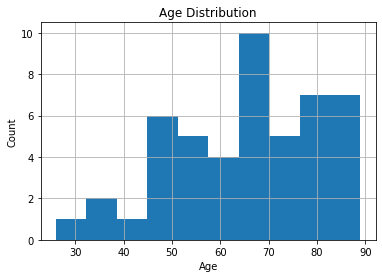

In [1511]:
# Age distribution

X_bal['age'].hist()
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xlabel('Age')

Text(0.5, 0, 'Height')

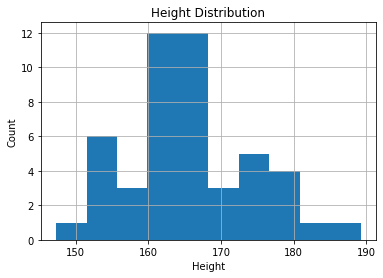

In [1512]:
# height distribution

X_bal['admissionheight'].hist()
plt.title('Height Distribution')
plt.ylabel('Count')
plt.xlabel('Height')

Text(0.5, 0, 'Weight')

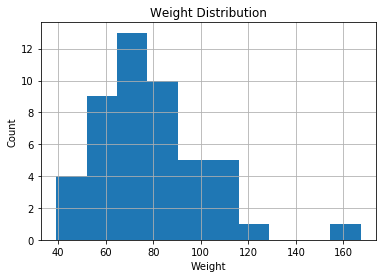

In [1513]:
# Weight distribution

X_bal['admissionweight'].hist()
plt.title('Weight Distribution')
plt.ylabel('Count')
plt.xlabel('Weight')

Text(0.5, 0, 'WBC')

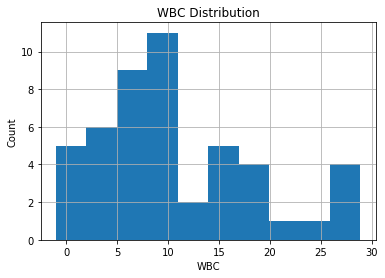

In [1514]:
# WBC distribution

X_bal['wbc'].hist()
plt.title('WBC Distribution')
plt.ylabel('Count')
plt.xlabel('WBC')

Text(0.5, 0, 'Temperature')

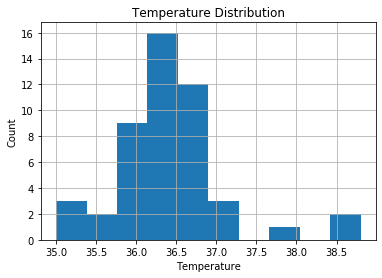

In [1515]:
# temperature distribution

X_bal['temperature'].hist()
plt.title('Temperature Distribution')
plt.ylabel('Count')
plt.xlabel('Temperature')

Text(0.5, 0, 'Mean BP')

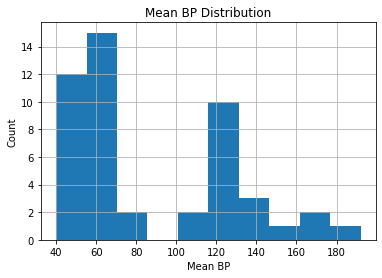

In [1516]:
# Mean BP distribution

X_bal['meanbp'].hist()
plt.title('Mean BP Distribution')
plt.ylabel('Count')
plt.xlabel('Mean BP')

Plotting these features allows for the designing of cohorts based on these patient characteristics. Although this isn't explored for the purpose of medication titration, I have included these examples here to allude to the idea that various cohorts can be designed to balanced these features. We have balanced the dosage/frequency combinations. This is shown below.

Text(0.5, 0, 'Dosage/Frequency Combination')

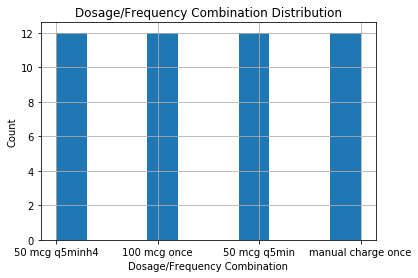

In [1517]:
fin_bal['dosfre'].hist()
plt.title('Dosage/Frequency Combination Distribution')
plt.ylabel('Count')
plt.xlabel('Dosage/Frequency Combination')

***

***

### Machine Learning for Dosage/Frequency Prediction

After restructing our dataset and making it balanced, we can finallly start making predictions using machine learning. Although this is by far the coolest part of the process, it less complicated than what we have already encountered. After much testing, the following models were used and compared amongst each other. 

1) Decision Tree Classifier

2) XGBoost

3) Neural Network (made with Keras and TensorFlow Backend)

Other models were tested, like K-Nearest Neighbors and Linear SVC, but they performed very poorly (< 20 % classification accuracy).

It is important to note that this is a classification problem and not a regression one. We are trying to classify patients to their actual drug dosage and frequencies using the features we have determined as potentially useful. I have attempted regression with the same dataset and many other datasets. However, the results were regression were very poor with the limited dataset size. The correlation coefficients between the features and targets are very small, making it difficult to use regression to predict ideal drug dosages. It also far more useful to treat this as a classification problem. In clinical practice, drug dosages are prescribed using the dosages avaiable on the market. Although it may be useful to get exact dosage amount to a few decimal places for a drug in some situations, it is far more relevant for the goal of the medication titration tool to predict what drug dosage a patient should recieve using the dosages available on the market. 

###### Metrics: Since this is a classification problem, we are going to use the F1 score, recall, and precision to determine the prediction quality for each model. We will use macro averaging since we have an equal amount of each target in our dataset. 

#### Decision Tree Classifier

In [1367]:
# Split our dataset into training set and testing set
# The stratify parameter will ensure we have equal ratios of each label in both the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.2, random_state=0, stratify=y_tran_bal)


In [1368]:
# Prevent extensive outpouring of warnings I have already address while
# testing this code
warnings.filterwarnings('ignore')

# Initialize decision tree classifier
dt_clf = DecisionTreeClassifier()

# Specify parameters for GridSearchCV. GridSearchCV will test out all these paramters iteratively and we can then use
# the best combination of these parameters.
depths = np.arange(1, 10)
num_leafs = [1, 5, 10, 20, 30, 40]
max_features = np.arange(1, len(X_train.columns))
param_grid = [{'min_samples_split': range(2, 10),
               'max_depth':depths,
               'min_samples_leaf':num_leafs,
               'max_features' : max_features}]

# Initialize the classifier with the paramaters and cross validation 
dt_clf_cv = GridSearchCV(DecisionTreeClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1_macro')

# Start using the decision tree on the data
dt_clf_cv.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n...
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,


In [1369]:
# Now let us store those parameters into our model and train again using that model
best_clf_tree_model = dt_clf_cv.best_estimator_
best_clf_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=73, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [1370]:
# We can see a chart of all the feature importances
importances_dict_dtc = dict(zip(X_bal.columns, best_clf_tree_model.feature_importances_))
dtc_imp_df = pd.DataFrame(list(importances_dict_dtc.items()),
                      columns=['Feature','Importance'])
display(dtc_imp_df)

Feature  Importance
0                                                  age    0.000000
1                                      admissionheight    0.000000
2                                      admissionweight    0.063216
3                                            intubated    0.079852
4                                                 vent    0.000000
5                                             dialysis    0.000000
6                                                 eyes    0.045154
7                                                motor    0.000000
8                                               verbal    0.000000
9                                                 meds    0.000000
10                                                 wbc    0.084288
11                                         temperature    0.000000
12                                     respiratoryrate    0.000000
13                                              meanbp    0.000000
14                                         gender_Male    0.000000
15                                       gender_Female    0.000000
16                          ethnicity_African American    0.000000
17                                     ethnicity_Asian    0.000000
18                                 ethnicity_Caucasian    0.000000
19                                  ethnicity_Hispanic    0.000000
20                           ethnicity_Native American    0.000000
21                             ethnicity_Other/Unknown    0.000000
22   apacheadmissiondx_ARDS-adult respiratory distr...    0.000000
23                apacheadmissiondx_Alcohol withdrawal    0.000000
24                       apacheadmissiondx_Anaphylaxis    0.000000
25                            apacheadmissiondx_Anemia    0.000000
26       apacheadmissiondx_Aneurysm, dissecting aortic    0.000000
27   apacheadmissiondx_Aneurysm, thoracic aortic; w...    0.000000
28   apacheadmissiondx_Aortic and Mitral valve repl...    0.000000
29   apacheadmissiondx_Aortic valve replacement (is...    0.000000
30   apacheadmissiondx_Arrest, respiratory (without...    0.000000
31                       apacheadmissiondx_Atelectasis    0.000000
32                 apacheadmissiondx_Biopsy, open lung    0.000000
33     apacheadmissiondx_Bleeding, GI-location unknown    0.000000
34                apacheadmissiondx_Bleeding, lower GI    0.000000
35                apacheadmissiondx_Bleeding, upper GI    0.000000
36   apacheadmissiondx_CABG alone, coronary artery ...    0.000000
37     apacheadmissiondx_CHF, congestive heart failure    0.000000
38   apacheadmissiondx_Cancer-colon/rectal, surgery...    0.000000
39   apacheadmissiondx_Cancer-small intestinal, sur...    0.000000
40   apacheadmissiondx_Cardiac arrest (with or with...    0.000000
41     apacheadmissiondx_Cardiovascular surgery, other    0.000000
42   apacheadmissiondx_Cellulitis and localized sof...    0.000000
43                  apacheadmissiondx_Cesarean section    0.000000
44   apacheadmissiondx_Coma/change in level of cons...    0.000000
45   apacheadmissiondx_Complications of previous GI...    0.000000
46   apacheadmissiondx_Cranioplasty and complicatio...    0.000000
47         apacheadmissiondx_Cystectomy, other reasons    0.000000
48   apacheadmissiondx_Defibrillator, automatic imp...    0.000000
49             apacheadmissiondx_Diabetic ketoacidosis    0.000000
50   apacheadmissiondx_Diverticular disease, surger...    0.000000
51            apacheadmissiondx_Efffusion, pericardial    0.000000
52              apacheadmissiondx_Emphysema/bronchitis    0.000000
53    apacheadmissiondx_Endarterectomy (other vessels)    0.000000
54           apacheadmissiondx_Endarterectomy, carotid    0.000000
55                      apacheadmissiondx_Endocarditis    0.000000
56         apacheadmissiondx_Esophageal surgery, other    0.000000
57   apacheadmissiondx_GI obstruction, surgery for ...    0.000000
58   apacheadmissiondx_GI perforation/rupture, surg...    0.000000
59      apacheadmissiondx_G

In [1371]:
# Let's make a prediction and calculate the f1-score, recall, and precision.
y_clf_pred = best_clf_tree_model.predict(X_test)

# We need to convert those predictions into actual dosage/frequency combinations by using the encoder we previously made
pred_names = le_bal.inverse_transform(y_clf_pred)

# Print results
print("F1 Score is: " + str(f1_score(y_test, y_clf_pred, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_clf_pred, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_clf_pred, average='macro')))

F1 Score is: 0.7916666666666666
Recall is: 0.7916666666666666
Precision is: 0.7916666666666666


In [1372]:
# Let us table the predictions vs the actual values for dosage/frequency combinations
estimated_decisions = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names}
pred_summary = pd.DataFrame.from_dict(estimated_decisions)
display(pred_summary)

Real Dosage/Frequencies Predicted Dosage/Frequencies
0          50 mcg q5minh4               50 mcg q5minh4
1            100 mcg once                 100 mcg once
2            100 mcg once                 100 mcg once
3            100 mcg once                 100 mcg once
4            50 mcg q5min               50 mcg q5minh4
5          50 mcg q5minh4                 50 mcg q5min
6      manual charge once           manual charge once
7            50 mcg q5min                 50 mcg q5min
8      manual charge once           manual charge once
9            50 mcg q5min                 50 mcg q5min

The Decision Tree Classifier (DTC) takes a very long time to run. The performance of the classifier will depend on the random_state, the number of samples (size of our dataset), and the train/test split. Some of these factors influence each other. For example, the choice of random_state can impact the results, but the influence of the random_state on the results will vary due to the size of the entire dataset and the size of the set that the model trains on after splitting the original data into a testing set and training set. This is because random_state will specify how the data is split into training and test set and in what order the data is split. Between two different random states, a data point may appear in either the training set of the test set. This is not so much an issue if we have thousands of data points to work with. The variablity in results will decrease the more data points we have and the confidence interval of our results will decrease. However, if we have very few data points, as in our case, the choice of random_state will yield varied results. 

Throughout the rest of this notebook, I have tried different random states for different models as well as the same random state for each model. I ultimately chose the random state that yielded the best results for each model. This is highly problematic in a real world case as it is not a reliable and scalable way to build these models. However, once enough data is obtained, the random_state parameter can be settled on one value and will not have to be changed. 

### XGBoost Classification

In [1585]:
# Split our dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.1, random_state=4, stratify=y_tran_bal)


In [1586]:
import xgboost as xgb
data_xgb_c = xgb.DMatrix(data=X_train, label=y_train)
nc = len(np.unique(y_tran_bal)) #s specifying the number of classes
xgb_params = {
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": nc+1,
    "objective": "multi:softmax", # important to specify this objective function for multi-class classification
    "num_class": nc+1,
    "eval_metric": "merror", # multi-class classification error rate
    "early_stopping_rounds": 100,
    "seed": 93808 # parameter similar to random_state
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data_xgb_c, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data_xgb_c, num_boost_round=1000, nfold=10,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=True),
                               xgb.callback.early_stop(10)])

[0]	train-merror:0.345074+0.115666	test-merror:0.56+0.308058
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 10 rounds.
[1]	train-merror:0.260796+0.051	test-merror:0.47+0.218174
[2]	train-merror:0.190891+0.0466811	test-merror:0.32+0.202731
[3]	train-merror:0.186032+0.0676892	test-merror:0.25+0.220227
[4]	train-merror:0.173347+0.058368	test-merror:0.275+0.204022
[5]	train-merror:0.144804+0.0313388	test-merror:0.3+0.214476
[6]	train-merror:0.152429+0.0332083	test-merror:0.3+0.214476
[7]	train-merror:0.142038+0.0415418	test-merror:0.3+0.214476
[8]	train-merror:0.131579+0.0418625	test-merror:0.325+0.221642
[9]	train-merror:0.136774+0.0426866	test-merror:0.3+0.214476
[10]	train-merror:0.131444+0.0501379	test-merror:0.3+0.214476
[11]	train-merror:0.115992+0.0443442	test-merror:0.275+0.204022
[12]	train-merror:0.118758+0.0344433	test-merror:0.3+0.266458
[13]	train-merror:0.110796+0.0456319	test-merror:0.3+

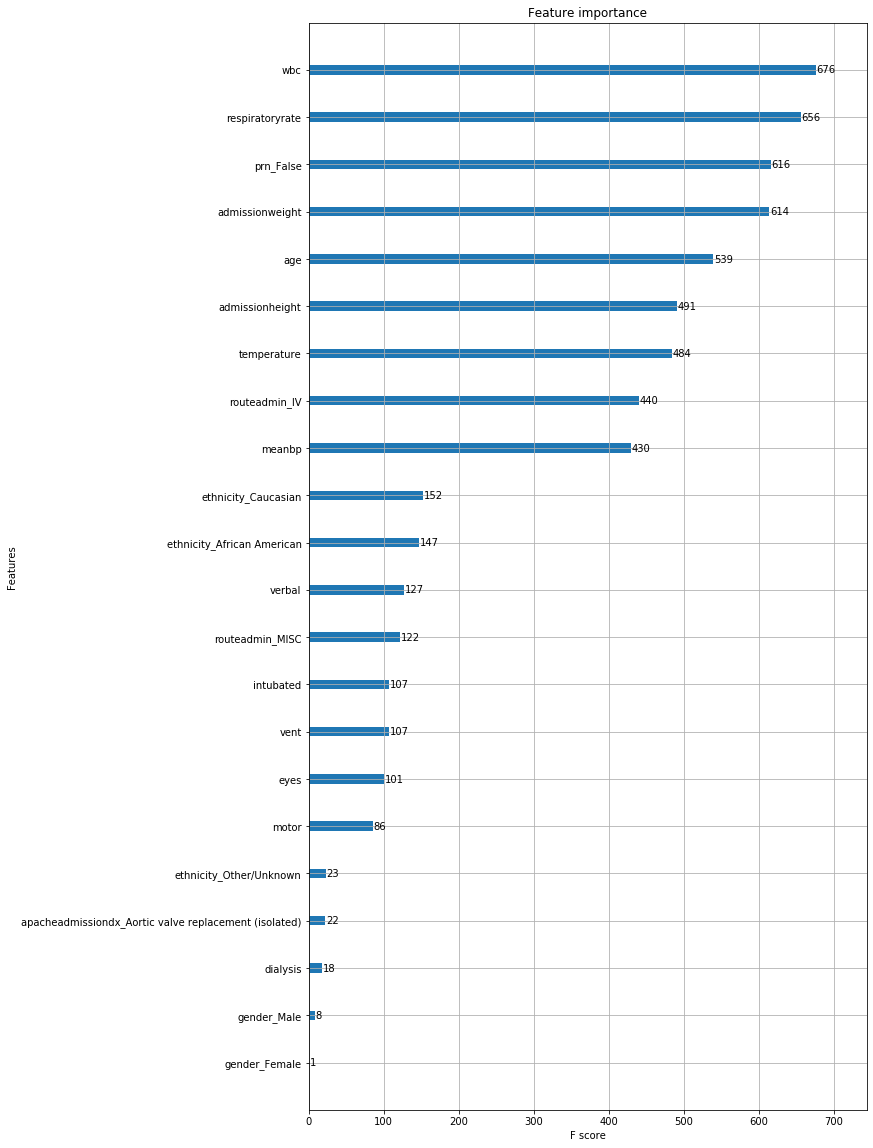

In [1588]:
# Let us see which features are most important for classification
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(xgbmodel, ax=ax)

In [1589]:
# Let us make predictions
y_test_pred_c = xgbmodel.predict(xgb.DMatrix(X_test))
y_test_pred_c_int = [int(i) for i in y_test_pred_c]
pred_names_xgb = le_bal.inverse_transform(y_test_pred_c_int)


In [1590]:
# Let us see how our model did
print("F1 Score is: " + str(f1_score(y_test, y_test_pred_c, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_test_pred_c, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_test_pred_c, average='macro')))

F1 Score is: 1.0
Recall is: 1.0
Precision is: 1.0


In [1575]:
estimated_decisions_xgb = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_xgb}
pred_summary = pd.DataFrame.from_dict(estimated_decisions_xgb)
display(pred_summary)

Real Dosage/Frequencies Predicted Dosage/Frequencies
0          50 mcg q5minh4               50 mcg q5minh4
1            50 mcg q5min                 50 mcg q5min
2      manual charge once           manual charge once
3            100 mcg once                 100 mcg once
4          50 mcg q5minh4               50 mcg q5minh4

XGBoost is a tree-based model like the DTC. However, XGBoost generally performs better amongst all the medication datasets used. It uses gradient boosting. In order to get a general understanding of gradient boosting, refer to this article (https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/). 

XGBoost parameters can be tuned to improve the performance, but I have settled on the paramters shown here. Varying the parameters, particularly the learning rate, has shown to change the F1 score by +/- .2 on average.

### Neural Network

In [1749]:
# Reinitialize the label encoder again because Keras requires the labels to be set to categorical values to be used 
# in the model. After that, train/test split again.

le_bal = preprocessing.LabelEncoder()
le_bal.fit(dos_fre_bal)
y_tran_bal = le_bal.transform(y_bal) 
y_tran_bal_cat = to_categorical(y_tran_bal)
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal_cat, test_size=0.1, random_state=420, stratify=y_tran_bal)

In [1750]:
# We will use the sequential model as we can simply stack layers onto the model. The format below allows for many layers to be added
# with various number of units.

model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(X_bal.shape[1],))) 
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))

# As we are doing multiclass classification, we will require the final layer to be a softmax activation function. 
model.add(Dense(y_train.shape[1], activation='softmax')) #Additional layer
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='categorical_crossentropy', #Multiclass classification loss
              metrics=['categorical_accuracy'])

print("These are the layers of the model:")
model.summary()

These are the layers of the model:
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_445 (Dense)            (None, 128)               13056     
_________________________________________________________________
dense_446 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_447 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_448 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_449 (Dense)            (None, 4)                 68        
Total params: 23,988
Trainable params: 23,988
Non-trainable params: 0
_________________________________________________________________


In [1751]:
# We can use early stopping to stop training when we begin to decrease in accuracy. I also pass patience to allow for small decreases
# before sharp increase in accuracy
es = EarlyStopping(monitor='val_categorical_accuracy', mode='min', verbose=0, patience=400)

# Save best model (will be saved in same directory location)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

Train on 43 samples, validate on 5 samples
Epoch 1/360

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to best_model.h5
43/43 - 0s - loss: 1.4754 - categorical_accuracy: 0.1860 - val_loss: 1.3611 - val_categorical_accuracy: 0.2000
Epoch 2/360

Epoch 00002: val_categorical_accuracy improved from 0.20000 to 0.40000, saving model to best_model.h5
43/43 - 0s - loss: 1.3489 - categorical_accuracy: 0.3721 - val_loss: 1.4242 - val_categorical_accuracy: 0.4000
Epoch 3/360

Epoch 00003: val_categorical_accuracy did not improve from 0.40000
43/43 - 0s - loss: 1.3966 - categorical_accuracy: 0.3488 - val_loss: 1.3634 - val_categorical_accuracy: 0.4000
Epoch 4/360

Epoch 00004: val_categorical_accuracy did not improve from 0.40000
43/43 - 0s - loss: 1.3109 - categorical_accuracy: 0.3953 - val_loss: 1.3770 - val_categorical_accuracy: 0.2000
Epoch 5/360

Epoch 00005: val_categorical_accuracy improved from 0.40000 to 0.60000, saving model to best_model.h5
43/43 - 0s 

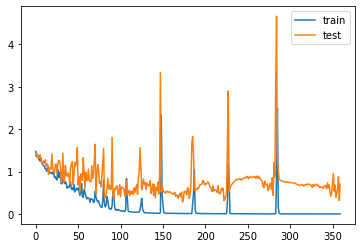

In [1752]:
# Run model
run_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=360, verbose=2, 
                    callbacks=[es, mc]
                   )
# Print results of model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# Plot training history of model
plt.plot(run_model.history['loss'], label='train')
plt.plot(run_model.history['val_loss'], label='test')
plt.legend()
plt.show()

In [1753]:
# Since the training and test set was made use the categorical labels, we need to remake the training and testing set
# It is important to use the same split and random_state as before, otherwise we will test on data points we have already trained for.
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_tran_bal, test_size=0.10, random_state=420, stratify=y_tran_bal)

In [1754]:
# Make Predictions
y_keras = model.predict_classes(X_test)
pred_names_keras = le_bal.inverse_transform(y_keras)

# Print results
print("F1 Score is: " + str(f1_score(y_test, y_keras, average='macro')))
print("Recall is: " + str(recall_score(y_test, y_keras, average='macro'))) 
print("Precision is: " + str(precision_score(y_test, y_keras, average='macro')))

estimated_decisions_knn = {'Real Dosage/Frequencies':le_bal.inverse_transform(y_test), 'Predicted Dosage/Frequencies': pred_names_keras}
pred_summary = pd.DataFrame.from_dict(estimated_decisions_knn)
display(pred_summary)

F1 Score is: 0.8333333333333333
Recall is: 0.875
Precision is: 0.875


Real Dosage/Frequencies Predicted Dosage/Frequencies
0      manual charge once           manual charge once
1            50 mcg q5min           manual charge once
2            50 mcg q5min                 50 mcg q5min
3          50 mcg q5minh4               50 mcg q5minh4
4            100 mcg once                 100 mcg once

Neural Networks generally perform very well with a large amount of data points. With smaller datasets like ours, the performance of the model is significantly reduced. The choice of activation function also greatly impacts the performance the model. Out of the three common ones: relu, tanh, and sigmoid, I have tanh to provide the best results. Relu often provides the worst results, while tanh consistently provides the best results. The most number of iterations needed before convergence was 2000. I have also found that the number of layers greatly impacts the performance for each different medication dataset required. This means that with one medication dataset and one combination of layers, I can get one set of results, but get a significantly different performance on another dataset and the same combination of layers. However, the latter dataset may actually lead to better performance with a different combination of layers. 

I have also noticed that the neural networks peforms fairly well on epochs <1000. After many epochs, the training and testing error greatly diverges and the performance of the model greatly decreases. Thus, for our small dataset, training on fewever epochs is the better choice. 

I believe that with more data points, the neural network will perform much better. However, before that happens, the neural network should not be used to make predictions. 

***

***

### Conclusions

After testing out these models on multiple medication datasets collected from BigQuery, I have determined that XGBoost holds the most promise for the medication titration tool. It consistently provides the best F1 score, recall, and precision, takes the shortest amount of time to train, and also offers a simple feature importance plot that can hold great value to doctors or care teams. Even when the model accuracy isn't optimal, the feature importance chart can help doctors or care teams determine what they should consider when prescribing a medication dosage or frequency. 

#### Insights on Data


Making models is the easier aspect of the entire process. The far more difficult aspect is the collection and organization of data.


##### Dataset Size
After processing each of the data provided in this folder, you will find that we are often left with less than 100 patients to draw predictions from. That is far too few patients. One of the big reasons for this is the imbalance of dosage/frequency combination labels. Earlier, we saw that we had many dosage/frequency combinations in our original dataset that only had 1 instance. This meant that even if we trained on those instances, we would no way to verify we learned how to predict those combinations. Additionally, if those instances appeared in the testing set but never in the training set, we would never be able to accuractly predict them. This this is the reason why we had to select a small subset of dosage/frequency combinations from our larger dataset. We lost many datapoints due to this. Thus, if we are to make dosage/frequency predictions for patients, we need to ensure that we not only have a lot of datapoints, but also more datapoints per category of dosage/frequency. In most of the examples used with this notebook, there were at most 12 samples per category with around 4-5 categories filtered out of the entire dataset. With so few samples per category to train on, our models often had difficulty in consistently correctly predicting dosage/frequency combinations. If we were to acquire enough data points for multiple dosage/frequency categories, we can use the code provided to make a final balanced dataset with multiple samples per category. For example, if we had 1000 data points and 10 categories for dosage/frequency combinations, we would 100 samples of each category in our final training set. Our models would likely produce superior results compared to what we have found thus far. In conclusion, we should aim to have

1) 1000+ individual patient data points
2) 100+ samples per dosage/frequency combination

##### Standardization of Frequencies and Dosages
You may have noticed that we had to change some of the frequency values in our original dataset due to the large amount of various ways doctors had written a frequency. For example, some doctors wrote 1xdaily while others wrote once a day. Some doctors wrote q6hr and others wrote q6h, even though they are the same frequency. This redundancy in frequencies causes by a lack of standard terminology on frequencies is highly problematic. It requires careful preproccessing and hinders any possibility of automating the preprocessing steps because one may have to convert some frequencies to a predetermined standard manually. Although this our pipeline takes care of the some of the redundancy found in the eICU database, we should aim to standardize the frequency terminology. We can use any terms used in LOINC or SNOMED for this purpose. The medication titration tool should offer options to doctors or other users to prescribe frequencies available in a drop down menu. This drop down menu should contain a large list of usable frequencies. This will ensure that no frequency is entered in a format that we have not already configured our pipeline for. If there exists a frequency we don't provide in that drop down menu, we can offer the chance to submit a frequency as free-text. We will then need to update our set of terms for frequency to always offer that term to users. Deciding on the best terms to use for frequency is something that we must work with doctors to do. As long as we offer freqency options in the medication titration tool that doctors are willing to use and patients are able to understand, we will be able to mitigate this issue. Although the issue was not encountered here, the reporting of dosages should also be standardized.

##### The Bottom Line
A standard terminology and a large amount of datapoints will significantly reduce the variability in our prediction accuracies. As of right now, we have chosen the best random_states to provide the best prediction accuracies. Although the accuracy doesn't change all that much from random_state to random_state, we need to collect enough data points to reduce the variance of our predictions. Only when we have reduced the variance such that we can consistently offer at least 95% prediction accuracy for medication dosage/frequency combinations can we reliably deploy our machine learning models to be used in conjunction with the medication titration tool.


#### How Will This Work With The Medication Titration Tool?
1) Physician will prescribe drug dosage and frequency to patient based on a set of vitals. 

2) If a patient encounters a condition that warrants a change in dosage or frequency, they will specify what has changed. This change must be a change in one of the features that our model makes predictions with (a column of our dataset). 

3) That change, along with the rest of their unchanged features, will serve as a testing row that will feed into our model to make predictions. 

4) Our model will make a prediction which will be provided to the physician. If the physician agrees with the prediction, then they will allow for that prediction of dosage and frequency to be given to the patient to follow. If the physician disagrees with the prediction, they can suggest a value for the dosage and frequency. This new suggestion will be sent to the patient. That new suggestion will also override the predicted dosage and frequency of the patient data point and will be sent to the model to be trained on once enough examples of the same dosage frequency combination is obtained. The physician will also recieve a feature importance chart that will specify what features they should consider most when deciding on a dosage/frequency combination for a patient. They will recieve such a chart regardless of their decision to accept or decline the prediction of our machine learning models.

##### Can we use different features than the ones used in this notebook example?
Yes. This notebook example verifies that we can use 1) patient vitals and disease states and 2) dosages and frequencies to build machine learning models that can then predict dosages and frequencies for a patient based on their vitals and disease states. Some of the features used to make predictions here will be the same as the ones used in the medication titration tool (such as height, weight, age, gender, etc). Some of th features explored in this notebook example may not be features in the final medication titration tool. There is room for exploration and the ideal model can only be developed in conjunction with the use of the tool itself. 



### Next Steps: Reinforcement Learning

Many advances have been made in providing ideal medication dosage and frequencies to patients suffering from sepsis by using reinforcement learning. Reinforcement learning is different from the general machine learning we have done in that reinforcement learning focuses on training an agent (computer that makes choices) to use a policy (method by which to make a decision) to maximize long term reward (reward as opposed to minimizing a loss function). There is much work to be done in this arena, but it may enable us to build a system that can find the optimal drug dosage and frequency for a patient for not only short term improvements in health, but also long term improvements in overall health. Such a system (or agent) will be able to provide even more valuable insights to physicians. 